In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import seaborn as sb
sb.set_style('darkgrid')

from glob import glob
import matplotlib.pyplot as plt
import os
import random
import cv2

import gzip
import nibabel as nb

In [4]:
# WARNING: takes ~3:49 mins
# if it's the first time you run the code, run this cell to convert .npy.gz files into .nii.gz
# if already done you should have .nii.gz files and can run the next cell directly (saving yourself some time)
# TODO: figure out if there is a way to do this that doesn't require changing to Nifti1Images
MriFiles = glob('/Volumes/DISK_IMG/10*/*T1w.npy.gz')
SosFiles = glob('/Volumes/DISK_IMG/10*/*Vp.npy.gz')

images = []
for i in range(len(MriFiles)):
    f1 = gzip.GzipFile(MriFiles[i], "r") # file type is now gzip.GzipFile
    data1 = np.load(f1)
    img1 = nb.Nifti1Image(data1,None)
    img1.header.get_xyzt_units()
    img1.to_filename(os.path.join('build', MriFiles[i].replace('.npy','.nii')))  # Save as NiBabel file

    f2 = gzip.GzipFile(SosFiles[i], "r") # file type is now gzip.GzipFile
    data2 = np.load(f2)
    img2 = nb.Nifti1Image(data2,None)
    img2.header.get_xyzt_units()
    img2.to_filename(os.path.join('build', SosFiles[i].replace('.npy','.nii')))  # Save as NiBabel file

In [5]:
MriFiles = glob('/Volumes/DISK_IMG/10*/*T1w.nii.gz')
SosFiles = glob('/Volumes/DISK_IMG/10*/*Vp.nii.gz')

MriIm = [] # array of full images containing header and data of MRIs
MriHdr = [] # array of only the headers of MRIs
MriData = [] # array of only the data of MRIs

# similarly, for speed of sound maps
SosIm = []
SosHdr = []
SosData = []
for i in range(len(MriFiles)):
    MriIm.append(nb.load(MriFiles[i]))
    MriHdr.append(MriIm[i].header)
    MriData.append(MriIm[i].get_fdata())

    SosIm.append(nb.load(SosFiles[i]))
    SosHdr.append(SosIm[i].header)
    SosData.append(SosIm[i].get_fdata())

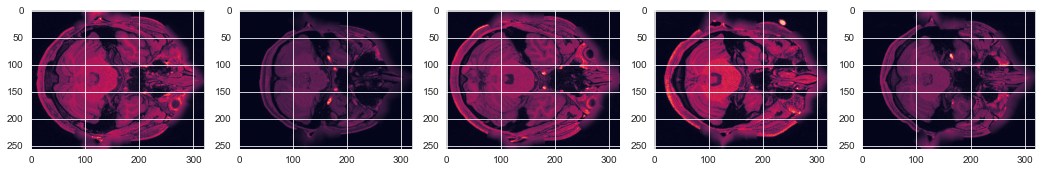

In [6]:
# Example of plotting a slice of each of our 5 MRIs
fig1 = plt.subplots(1,5,figsize=(18,18))
for i in range(len(MriIm)):
    z_slice = MriData[i][:,:,100]
    plt.subplot(1,5,i+1)
    plt.imshow(z_slice)

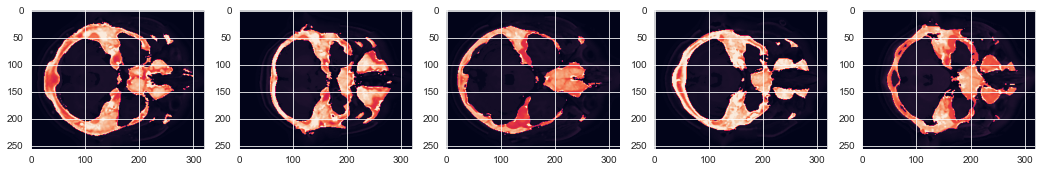

In [7]:
# these are the exact same slices of the SoS maps
fig2 = plt.subplots(1,5,figsize=(18,18))
for i in range(len(SosIm)):
    z_slice = SosData[i][:,:,100]
    plt.subplot(1,5,i+1)
    plt.imshow(z_slice)

In [9]:
# put all the scans of all MRIs as members of a dataframe so that each cell of each row is a whole image
MriDf = pd.DataFrame()
for scan in range(len(MriData)):
    Mri = MriData[scan]
    for slice in range(len(Mri[1,1,:])):
        temp = {'img' : [Mri[:,:,slice]]}
        tempDf = pd.DataFrame.from_records(temp)
        MriDf = MriDf.append(tempDf)
print(MriDf.shape)

(1600, 1)


(256, 320)


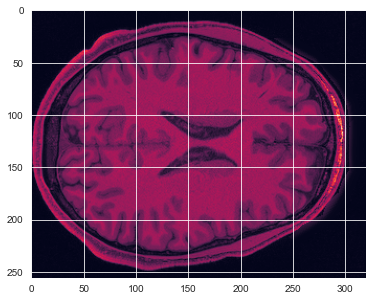

In [11]:
# check a single image is in each cell: should output a picture like the ones above
print(MriDf.iloc[0][0].shape)
plt.figure(figsize = (6,6))
plt.imshow(MriDf.iloc[180][0]);

In [12]:
# similarly, creating a dataframe where each cell is a SoS image
SosDf = pd.DataFrame()
for scan in range(len(SosData)):
    Sos = SosData[scan]
    for slice in range(len(Sos[1,1,:])):
        temp = {'img' : [Sos[:,:,slice]]}
        tempDf = pd.DataFrame.from_records(temp)
        SosDf = SosDf.append(tempDf)
print(SosDf.shape)
# note that both dataframes are aligned: skull 3 in MriDf is also 3 in SosData

(1600, 1)


In [16]:
# merging both databases into one, with a column being for MriDf and another for SosDf
df = pd.concat([MriDf, SosDf], axis=1)
df.columns = ['MRI','SoS']
df.head()


,MRI,SoS
0,"[[32.05524826049805, 72.65767669677734, 19.232...","[[1480.0, 1480.0, 1480.0, 1480.0, 1480.0, 1480..."
0,"[[32.053810119628906, 45.943233489990234, 26.7...","[[1480.0, 1480.0, 1480.0, 1480.0, 1480.0, 1480..."
0,"[[38.461997985839844, 54.48716354370117, 16.02...","[[1480.0, 1480.0, 1480.0, 1480.0, 1480.0, 1480..."
0,"[[19.22929573059082, 53.4140510559082, 41.6621...","[[1480.0, 1480.0, 1480.0, 1480.0, 1480.0, 1480..."
0,"[[11.749947547912598, 24.567768096923828, 25.6...","[[1480.0, 1480.0, 1480.0, 1480.0, 1480.0, 1480..."


In [17]:
# separating the dataframe into train, test and validation data. Most data kept in 
# training, then test and validation has the least
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(1156, 2)
(204, 2)
(240, 2)


In [21]:
# separating each into X and y
# unsure if this is necessary, but all of the above are pandas series now so transforming them
# back into pandas dataframes with .to_frame()
df_train_X = df_train['MRI'].to_frame('MRI') 
df_train_y = df_train['SoS'].to_frame('SoS')

df_test_X = df_test['MRI'].to_frame('MRI')
df_test_y = df_test['SoS'].to_frame('SoS')

df_val_X = df_val['MRI'].to_frame('MRI')
df_val_y = df_val['SoS'].to_frame('SoS')

In [26]:
print("There are " + str(df_train_X.shape) + " MRI scans for training")
print("There are " + str(df_train_y.shape) + " SoS scans for training")
print("MRI Image shape = " + str(df_train_X.iloc[0][0].shape))
print("SoS Image shape = " + str(df_train_y.iloc[0][0].shape))

There are (1156, 1) MRI scans for training
There are (1156, 1) SoS scans for training
MRI Image shape = (256, 320)
SoS Image shape = (256, 320)


In [27]:
# this was my attempt at making things into floats so my model gets fitted correctly. sadly didnt work
# df_train_X['MRI'] = np.array(df_train_X['MRI'], dtype=float) #  convert using numpy
# df_train_y['SoS'] = np.array(df_train_y['SoS'], dtype=float)

df_train_X = df_train_X.fillna(0)
df_train_y = df_train_y.fillna(0)

In [28]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()

In [29]:
linear.fit([df_train_X], [df_train_y])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:956: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(


ValueError: Unable to convert array of bytes/strings into decimal numbers with dtype='numeric'